In [1]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from gpjax.kernels.base import AdditiveKernel


import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb

# custom bits
from gpjax.dataset import VerticalDataset
from gpjax.kernels.stationary.rbf import OrthogonalRBF, OrthogonalRBFUnif
from gpjax.gps import CustomAdditiveConjugatePosterior, VerticalSmoother
from gpjax.objectives import CustomConjugateMLL, CustomELBO, custom_variational_expectation
from gpjax.optim_utils import optim_builder, zero_grads
from gpjax.variational_families import CustomVariationalGaussian


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [39]:
# load data
X2d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X2d_sample.npy"), dtype=jnp.float64) # [N, D]
X3d_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/X3d_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/XStatic_sample.npy"), dtype=jnp.float64) # [N, D]
Y_raw = jnp.array(jnp.load("../data/ERA/NPY_DATA/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)

# random shuffle
X2d = jr.permutation(key, X2d_raw)
X3d = jr.permutation(key, X3d_raw)
Xstatic = jr.permutation(key, Xstatic_raw)
Y = jr.permutation(key, Y_raw)

# look at ERA5 rain
Y = Y[:,0:1]  




# just keep the "prognostic" 3d inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
idx_3d = [i for i in range(len(names_3d))]
# idx_3d = [1, 7, 8, 9]
names_3d = [names_3d[i] for i in idx_3d]
X3d = X3d[:,idx_3d,:]


# # also use his "normalisatopm" for sigma_o
# sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2])) # optimize threshold?
# Xstatic = Xstatic.at[:,2].set(sigma_o)
names_static = ["LSM","O_angle","O_sd","O_slope"]
idx_static = [i for i in range(len(names_static))]
# idx_static = [0]
#idx_static = []
names_static = [names_static[i] for i in idx_static]
Xstatic = Xstatic[:,idx_static]


names_2d = ["K_surface","flux_s","flux_l","moisture","CRH"]
idx_2d =[i for i in range(len(names_2d))]
idx_2d = [1,2,3,4]
names_2d = [names_2d[i] for i in idx_2d]
X2d = X2d[:,idx_2d]


#remove all pressure levels above 500 hPA
lowest_idx =  11 #7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]
pressure_mean = jnp.mean(pressure_levels)
pressure_std = jnp.std(pressure_levels)
pressure_levels = (pressure_levels - pressure_mean) / pressure_std



# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# # remove no rain days
# print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
# X3d = X3d[Y[:,0]>0,:]
# X2d = X2d[Y[:,0]>0,:]
# Xstatic = Xstatic[Y[:,0]>0,:]
# Y = Y[Y[:,0]>0,:]


# also log Y
# print(f"Applied log transform to Y")
#Y = jnp.log(Y-jnp.min(Y)+1e-1)


num_2d_variables= X2d.shape[1]
num_3d_variables= X3d.shape[1]
num_static_variables= Xstatic.shape[1]
num_not_3d_variables = num_2d_variables + num_static_variables
num_variables = num_2d_variables + num_3d_variables + num_static_variables
print(f"using {num_static_variables} static variables")
print(f"using {num_2d_variables} 2d variables")
print(f"using {num_3d_variables} 3d variables")
names = names_3d + names_2d + names_static
print(f"using variables with names {names}")








Removed all pressure levels below [50000.] hPa
Removed 25 entries with nan
using 4 static variables
using 4 2d variables
using 11 3d variables
using variables with names ['K,', 'RH', 'q', 'gh', 'wind_z', 'wind_m', 'theta', 'tehta_e', 'theta_e+', 'theta_e*', 'plume', 'flux_s', 'flux_l', 'moisture', 'CRH', 'LSM', 'O_angle', 'O_sd', 'O_slope']


In [40]:
def plot_params(model, title=""):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    lengthscales = jnp.array([model.base_kernels[i].lengthscale[0] for i in range(len(model.base_kernels))])
    z_to_plot = jnp.linspace(jnp.min(model.smoother.Z_levels),jnp.max(model.smoother.Z_levels),100)
    smoothing_weights = model.smoother.smooth_fn(z_to_plot) 
    z_unscaled = z_to_plot * pressure_std+ pressure_mean
    for i in range(num_3d_variables):
        plt.plot(smoothing_weights[i,:].T,z_unscaled, label=f"{names_3d[i]} with lengthscales_ {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f" other lengthscales are {lengthscales[num_3d_variables:]}")
    
def plot_interactions(model, data, k=10):
    plt.figure()
    idx_2 = []
    for i in range(num_variables):
        for j in range(i+1,num_variables):
            idx_2.append([i,j])
    idxs = [[]] + [[i] for i in range(num_variables)] + idx_2
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        sobols = model.get_sobol_indicies(idxs)
        z = model.inducing_inputs
    else:
        sobols = model.get_sobol_indicies(data, idxs)
        z = model.smoother.smooth_data(data)[0]
    sobols = sobols / jnp.sum(sobols)

    plt.plot(sobols)
    plt.title("sobol indicies (red lines between orders)")
    plt.axvline(x=1, color="red")
    plt.axvline(x=num_variables+1, color="red")
    for idx in jax.lax.top_k(sobols, k)[1]:
        chosen_idx = idxs[idx]
        plt.figure()
        num_plot = 1_000 if len(chosen_idx)==1 else 10_000
        x_plot = jr.uniform(key, (num_plot, num_variables), minval=jnp.min(z, axis=0), maxval=jnp.max(z, axis=0))
        if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
            posterior_dist = model.predict(x_plot,chosen_idx)
        else:
            posterior_dist = model.predict(x_plot, data, chosen_idx)
        mean = posterior_dist.mean() * Y_std + Y_mean
        std = jnp.sqrt(posterior_dist.variance())* Y_std
        if len(chosen_idx)==1:
            plt.scatter(x_plot[:,chosen_idx[0]],mean, color="blue") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean+ 1.96*std, color="red") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean- 1.96*std, color="red") 
            plt.xlim([jnp.min(x_plot[:,chosen_idx[0]]),jnp.max(x_plot[:,chosen_idx[0]])])
            plt.scatter(z[:,chosen_idx[0]],jnp.zeros_like(z[:,chosen_idx[0]]), color="black")
        elif len(chosen_idx)==2:
            col = plt.scatter(x_plot[:,chosen_idx[0]],x_plot[:,chosen_idx[1]],c=mean)
            plt.ylim([jnp.min(z[:,chosen_idx[1]]),jnp.max(z[:,chosen_idx[1]])])
            plt.colorbar(col)
            plt.scatter(z[:,chosen_idx[0]],z[:,chosen_idx[1]], color="black")
        plt.xlim([jnp.min(x_plot[:,chosen_idx[0]]),jnp.max(x_plot[:,chosen_idx[0]])])   
        plt.title(f"variable {[names[i] for i in chosen_idx]} with sobol index {sobols[idx]}")
        
        
    #     top_idx = jax.lax.top_k(sobols, k)[1]
    # zeroth = self.predict_additive_component(x, train_data, []).mean()[0]
    # plt.figure()
    # plt.hist(train_data.y.T, label="data")
    # plt.hist(jnp.sum(mean_components[:,:,0],0).T+ zeroth, label="all components")
    # plt.hist(jnp.sum(mean_components[:,:,0][top_idx],0).T + zeroth, label=f"top {k} components")
    # plt.legend()
    

In [15]:
from typing import List, Union, Callable
from jaxtyping import Num, Float
from gpjax.typing import Array, ScalarFloat
from beartype.typing import Optional
from gpjax.base import Module, param_field,static_field
import cola
from jax import vmap

@dataclass
class ConjugatePrecipGP(Module):
    base_kernels:List[gpx.kernels.AbstractKernel]
    likelihood: gpx.likelihoods.AbstractLikelihood
    smoother: VerticalSmoother
    max_interaction_depth: bool = static_field(2)
    interaction_variances: Float[Array, " D"] = param_field(jnp.array([1.0,1.0,1.0]), bijector=tfb.Softplus(low=jnp.array(1e-3, dtype=jnp.float64)))
    jitter: float = static_field(1e-6)
    zeroth_order: bool = static_field(True)
    
    def __post_init__(self):
        self.mean_function = gpx.mean_functions.Zero()
        if self.zeroth_order:
            if not self.max_interaction_depth == len(self.interaction_variances) - 1:
                raise ValueError("Number of interaction variances must be equal to max_interaction_depth + 1")
        else:
            if not self.max_interaction_depth == len(self.interaction_variances):
                raise ValueError("Number of interaction variances must be equal to max_interaction_depth")
        
        
    def predict(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: VerticalDataset,
        component_list: Optional[List[List[int]]]=None,
    ) -> Union[GaussianDistribution,  Num[Array, "N 1"]]:
        r"""Get the posterior predictive distribution (for a specific additive component if componen specified)."""
        #smooth data to get in form for preds
        x, y = self.smoother.smooth_data(train_data)
        t = test_inputs
        
        obs_noise = self.likelihood.obs_stddev**2
        mx = self.mean_function(x)
        mt = self.mean_function(t)
        
        
        Kxx = self.eval_K_xt(x, x) # [N, N]
        Kxx += cola.ops.I_like(Kxx) * self.jitter
        Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
        Sigma = cola.PSD(Sigma)
        
        if component_list is None:
            Ktt = self.eval_K_xt(t,t)
            Kxt = self.eval_K_xt(x,t)
        else:
            Ktt = self.eval_specific_K_xt(t, t, component_list)
            Kxt = self.eval_specific_K_xt(x, t, component_list)
        Sigma_inv_Kxt = cola.solve(Sigma, Kxt)


        mean = mt + jnp.matmul(Sigma_inv_Kxt.T, y - mx)
        covariance = Ktt - jnp.matmul(Kxt.T, Sigma_inv_Kxt)
        covariance += cola.ops.I_like(covariance) * self.jitter
        covariance = cola.PSD(covariance)
        return GaussianDistribution(jnp.atleast_1d(mean.squeeze()), covariance)
    

    def eval_K_xt(self, x: Num[Array, "N d"], t: Num[Array, "M d"]) -> Num[Array, "N M"]:
        ks = jnp.stack([k.cross_covariance(x,t) for k in self.base_kernels]) # [d, N, M]
        ks_orthogonal = self._orthogonalise(ks)
        if self.zeroth_order:
            return jnp.sum(self._compute_additive_terms_girad_newton(ks_orthogonal) * self.interaction_variances[:, None, None], 0)
        else:
            return jnp.sum(self._compute_additive_terms_girad_newton(ks_orthogonal)[1:,:,:] * self.interaction_variances[:, None, None], 0)
        
    def eval_specific_K_xt(self, x: Num[Array, "N d"], t: Num[Array, "M d"], component_list: List[int])-> Num[Array, "N M"]:
        ks = jnp.stack([self.base_kernels[i].cross_covariance(x,t) for i in component_list]) # [p, N, M]
        var = self.interaction_variances[len(component_list)]
        return var * jnp.prod(self._orthogonalise(ks),0) # [p, N, M]
        
        
    def _orthogonalise(self, ks: Num[Array, "d N M"])->Num[Array, "d N M"]:
        denom = jnp.sum(ks, (1,2))[:, None, None] # [d]
        Kx =  jnp.sum(ks, -1) # [d, N]
        Ky = jnp.sum(ks, 1) # [d, M]
        numerator = jnp.matmul(Kx[:,:,None], Ky[:, None, :])# [d, N, M]
        return ks -  numerator / denom 


    @jax.jit   
    def _compute_additive_terms_girad_newton(self, ks: Num[Array, "D N N"]) -> Num[Array, "p N N"]:
        N = jnp.shape(ks)[-1]
        powers = jnp.arange(self.max_interaction_depth + 1)[:, None] # [p + 1, 1]
        s = jnp.power(ks[None, :,:,:],powers[:,:,None,None]) # [p + 1, d, N, N]
        e = jnp.ones(shape=(self.max_interaction_depth+1, N, N), dtype=jnp.float64) # [p+1, N, N]lazy init then populate
        for n in range(1, self.max_interaction_depth + 1): # has to be for loop because iterative
            thing = jax.vmap(lambda k: ((-1.0)**(k-1))*e[n-k]*jnp.sum(s[k], 0))(jnp.arange(1, n+1))
            e = e.at[n].set((1.0/n) *jnp.sum(thing,0))
        return e
    
    def loss_fn(self, negative=False, log_prior: Optional[Callable] = None)->gpx.objectives.AbstractObjective:
        class Loss(gpx.objectives.AbstractObjective):
            def step(
                self,
                posterior: ConjugatePrecipGP,
                train_data: gpx.Dataset,
            ) -> ScalarFloat:
                #smooth data to get in form for preds
                x, y = posterior.smoother.smooth_data(train_data)
                
                obs_noise = posterior.likelihood.obs_stddev**2
                mx = posterior.mean_function(x)
                Kxx = posterior.eval_K_xt(x,x) # [N, N]
                # Σ = (Kxx + Io²) = LLᵀ
                Kxx += cola.ops.I_like(Kxx) * posterior.jitter
                Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
                Sigma = cola.PSD(Sigma)

                # p(y | x, θ), where θ are the model hyperparameters:
                mll = GaussianDistribution(jnp.atleast_1d(mx.squeeze()), Sigma)
                log_prob =jnp.array(0.0, dtype=jnp.float64)
                if log_prior is not None:
                    log_prob += log_prior(posterior)
                return self.constant * (mll.log_prob(jnp.atleast_1d(y.squeeze())).squeeze() + log_prob.squeeze())
            
        return Loss(negative=negative)


    def get_sobol_indicies(self, train_data: VerticalDataset, component_list: List[List[int]]) -> Num[Array, "c"]:
        if not isinstance(component_list, List):
            raise ValueError("Use get_sobol_index if you want to calc for single components (TODO)")
        x,y = self.smoother.smooth_data(train_data)
        m_x = self.mean_function(x)


        Kxx_indiv = jnp.stack([k.gram(x).to_dense() for k in self.base_kernels], axis=0) # [d, N, N]
        Kxx_indiv =  self._orthogonalise(Kxx_indiv)
        Kxx_components = [self.interaction_variances[len(c)]*jnp.prod(Kxx_indiv[c, :, :], axis=0) for c in component_list] 
        Kxx_components = jnp.stack(Kxx_components, axis=0) # [c, N, N]
        assert Kxx_components.shape[0] == len(component_list)

        Kxx = self.eval_K_xt(x,x)
        Sigma = cola.PSD(Kxx + cola.ops.I_like(Kxx) * (self.likelihood.obs_stddev**2+self.jitter))

        def get_mean_from_covar(K): # [N,N] -> [N, 1]
            Sigma_inv_Kxx = cola.solve(Sigma, K)
            return m_x + jnp.matmul(Sigma_inv_Kxx.T, y - m_x) # [N, 1] 

        mean_overall =  get_mean_from_covar(Kxx) # [N, 1]
        mean_components = vmap(get_mean_from_covar)(Kxx_components) # [c, N, 1]

        sobols = jnp.var(mean_components[:,:,0], axis=-1) / jnp.var(mean_overall) # [c]
        return sobols
    
    
    
    
# @dataclass
# class NonConjugatePrecipGP(ConjugatePrecipGP):
#     inducing_inputs: Float[Array, "N D"]
#     variational_mean: Union[Float[Array, "N 1"], None] = param_field(None)
#     variational_root_covariance: Float[Array, "N N"] = param_field(
#         None, bijector=tfb.FillTriangular()
#     )



In [30]:
def build_log_prior(tau=None) -> callable:

    def log_prior(model):
        log_prob = 0.0

        # if hasattr(model, "smoother"):
        #     smoother_input_scale_prior = tfd.LogNormal(0.0,1.0)
        #     smoother_mean_prior = tfd.Uniform(jnp.min(model.smoother.Z_levels),jnp.max(model.smoother.Z_levels))
        #     log_prob += jnp.sum(smoother_mean_prior.log_prob(model.smoother.smoother_mean))
        #     log_prob += jnp.sum(smoother_input_scale_prior.log_prob(model.smoother.smoother_input_scale))

        lengthscales = jnp.vstack([k.lengthscale for k in model.base_kernels])
        variances = model.interaction_variances
       
        variance_prior = tfd.Gamma(1.0,0.2)
        log_prob += jnp.sum(variance_prior.log_prob(variances))

        # d = lengthscales.size
        # #l_prior = tfd.LogNormal(jnp.sqrt(2.0) + jnp.log(d)/2.0,jnp.sqrt(1.0))
        # #l_prior = tfd.Gamma(3.0*d,6.0)
        #l_prior = tfd.Gamma(3.0,6.0)
        #log_prob += jnp.sum(l_prior.log_prob(lengthscales))
        l_prior = tfd.HalfCauchy(0.0,tau)
        log_prob += jnp.sum(l_prior.log_prob((1.0 / lengthscales**2)))
            
        noise_prior = tfd.LogNormal(0.0,10)
        log_prob += noise_prior.log_prob(model.likelihood.obs_stddev)

        return log_prob
    
    return log_prior



def init_smoother():
    smoother_input_scale_bijector = tfb.Softplus(low=jnp.array(1e-1, dtype=jnp.float64))
    smoother_mean_bijector =  tfb.SoftClip(low=jnp.min(pressure_levels+1e-3), high=jnp.max(pressure_levels-1e-3))
    smoother = VerticalSmoother(
        jnp.array([[0.0]*num_3d_variables]), 
        jnp.array([[1.0]*num_3d_variables]), 
        Z_levels=pressure_levels
        ).replace_bijector(smoother_input_scale=smoother_input_scale_bijector,smoother_mean=smoother_mean_bijector)
    return smoother


def init_kernels(data):
    lengthscale_bij = tfb.SoftClip(low=jnp.array(1e-1, dtype=jnp.float64))#, high=jnp.array(1e3, dtype=jnp.float64))
    return  [gpx.kernels.RBF(lengthscale=jnp.array([1.0]), active_dims=[i]).replace_trainable(variance=False).replace_bijector(lengthscale = lengthscale_bij) for i in range(data.dim)]

def init_likelihood(data):
    obs_bij=tfb.Softplus(low=jnp.array(1e-2, dtype=jnp.float64))
    return gpx.likelihoods.Gaussian(num_datapoints=data.n, obs_stddev=jnp.array(1.0, dtype=jnp.float64)).replace_bijector(obs_stddev=obs_bij)




standardized inputs with max and min
then standardized Y as Gaussian


TypeError: Argument 'flux_s' of type <class 'str'> is not a valid JAX type

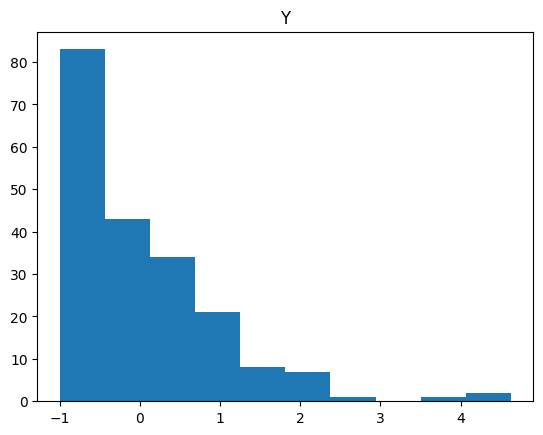

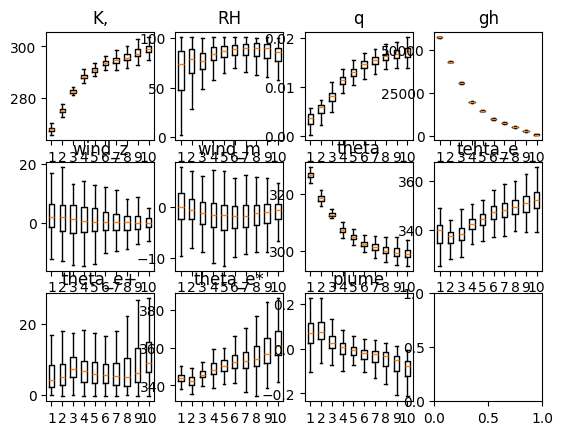

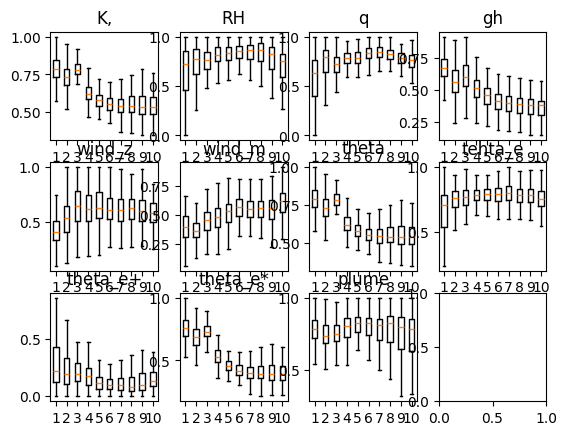

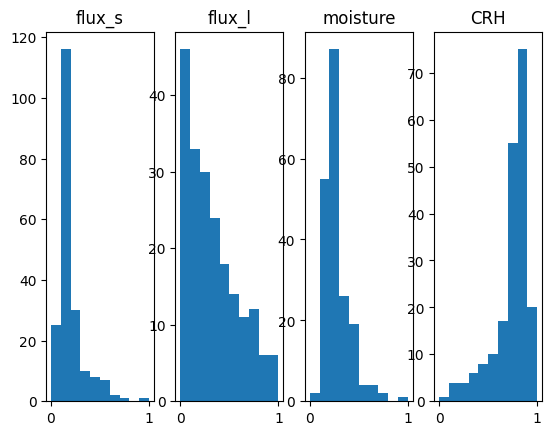

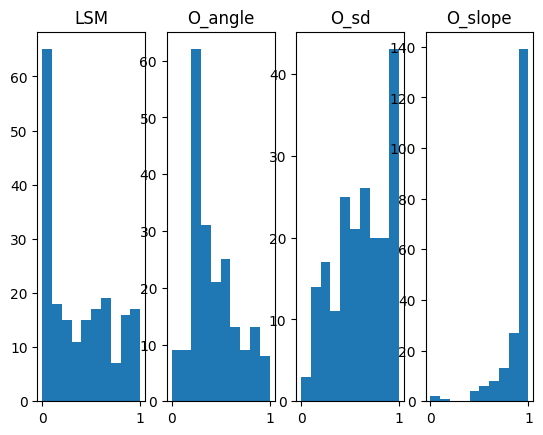

<Figure size 640x480 with 0 Axes>

In [46]:
# prep fancy kernel for model
# first fit with small data to get init for SVGP
num_data_for_init=200
D_small = VerticalDataset(
    X2d_raw = X2d[:num_data_for_init,:],
    X3d_raw = X3d[:num_data_for_init,:,:],
    Xstatic_raw = Xstatic[:num_data_for_init,:],
    y_raw=Y[:num_data_for_init,:],
    names_3d=names_3d,
    names_2d=names_2d,
    names_static=names_static,
)


# fit with small data
posterior = ConjugatePrecipGP(
    base_kernels=init_kernels(D_small), 
    likelihood=init_likelihood(D_small), 
    smoother=init_smoother(),
    zeroth_order=True,
    max_interaction_depth=2,
    interaction_variances=jnp.array([1.0, 1.0,1.0], dtype=jnp.float64),
    )
plt.figure()
opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=jax.jit(posterior.loss_fn(negative=True, log_prior=None)),
        train_data=D_small,
        safe=False,
    )
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")
print(f"noise is {opt_posterior.likelihood.obs_stddev}")
print(f"interaction vars {opt_posterior.interaction_variances}")
plot_interactions(opt_posterior, D_small, k=10)